Loading and preparing data...
Data prepared:
  Training samples: 120
  Testing samples: 30
  Number of features: 4
  Number of classes: 3
------------------------------
Model Architecture:
SimpleANN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)
------------------------------
Using Loss Function: CrossEntropyLoss()
Using Optimizer: Adam with lr=0.01
------------------------------
Starting training for 100 epochs...
Epoch [10/100], Loss: 0.1319
Epoch [20/100], Loss: 0.0525
Epoch [30/100], Loss: 0.0455
Epoch [40/100], Loss: 0.0538
Epoch [50/100], Loss: 0.0398
Epoch [60/100], Loss: 0.0528
Epoch [70/100], Loss: 0.0362
Epoch [80/100], Loss: 0.0322
Epoch [90/100], Loss: 0.0409
Epoch [100/100], Loss: 0.0247
Training finished.
------------------------------
Evaluating model on test data...
Accuracy on the test set: 96.67%
------------------------------


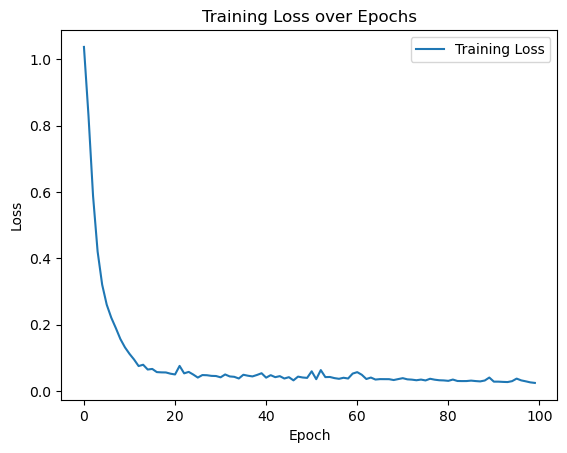


Prediction for sample [5.1 3.5 1.4 0.2]: setosa (Class index: 0)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # Contains activation functions like ReLU
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 0. Set random seed for reproducibility (optional)
# torch.manual_seed(42)
# np.random.seed(42)

# 1. Load and Prepare the Iris Dataset
print("Loading and preparing data...")
iris = load_iris()
X = iris.data
y = iris.target

# Split data into training and testing sets
# stratify=y ensures that the proportion of classes is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features: Important for ANNs!
# Fit scaler ONLY on training data, then transform both train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on train data

# Convert data to PyTorch Tensors
# Features should be FloatTensor, labels should be LongTensor for CrossEntropyLoss
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders for batching
batch_size = 16 # Small batch size suitable for this small dataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data

print(f"Data prepared:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Testing samples: {len(test_dataset)}")
print(f"  Number of features: {X_train_tensor.shape[1]}")
print(f"  Number of classes: {len(np.unique(y))}")
print("-" * 30)

# 2. Define the Neural Network Model (ANN/MLP)
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleANN, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1) # Input layer to hidden layer 1
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(hidden_size2, output_size) # Hidden layer 2 to output layer

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x)) # Activation function after first hidden layer
        x = F.relu(self.fc2(x)) # Activation function after second hidden layer
        x = self.fc3(x)         # No activation function here - CrossEntropyLoss expects raw logits
        return x

# Instantiate the model
input_dim = X_train_tensor.shape[1] # Should be 4 for Iris
hidden_dim1 = 10 # Example hidden layer size
hidden_dim2 = 8  # Example second hidden layer size
output_dim = len(np.unique(y)) # Should be 3 for Iris classes

model = SimpleANN(input_dim, hidden_dim1, hidden_dim2, output_dim)
print("Model Architecture:")
print(model)
print("-" * 30)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Using Loss Function: {criterion}")
print(f"Using Optimizer: Adam with lr={learning_rate}")
print("-" * 30)

# 4. Training Loop
num_epochs = 100
print(f"Starting training for {num_epochs} epochs...")

train_losses = [] # To store loss per epoch

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # Weighted average

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training finished.")
print("-" * 30)

# 5. Evaluate the Model
print("Evaluating model on test data...")
model.eval() # Set the model to evaluation mode (important for layers like Dropout, BatchNorm)

all_preds = []
all_labels = []

# No need to track gradients during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get predictions: The class with the highest score is the prediction
        _, predicted = torch.max(outputs.data, 1) # Returns max value, max indices
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
print("-" * 30)

# Optional: You can plot the training loss if needed
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Example: Make a prediction on a new sample (needs scaling)
# Make sure the new sample has the same number of features (4)
new_sample_np = np.array([[5.1, 3.5, 1.4, 0.2]]) # Example: corresponds to Iris Setosa
new_sample_scaled = scaler.transform(new_sample_np) # Use the SAME scaler
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    prediction_outputs = model(new_sample_tensor)
    _, predicted_class = torch.max(prediction_outputs.data, 1)
    predicted_species = iris.target_names[predicted_class.item()]
    print(f"\nPrediction for sample {new_sample_np[0]}: {predicted_species} (Class index: {predicted_class.item()})")

In [7]:
# First, make sure you have torchsummary installed in your environment
# You might need to run this in a cell once:

import torch
from torchsummary import summary

# Assuming 'model' and 'input_dim' variables are already defined from the previous cell
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device before creating the summary
model.to(device)

# Print the summary
# input_size should be the shape of a single input sample (e.g., (4,) for Iris)
print("Model Summary:")
summary(model, input_size=(input_dim,))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              50
            Linear-2                    [-1, 8]              88
            Linear-3                    [-1, 3]              27
Total params: 165
Trainable params: 165
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [8]:

from torchinfo import summary 

# Assuming 'model' and 'input_dim' variables are already defined from the previous cell
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device before creating the summary
model.to(device)

# Print the summary
# input_size should be the shape of a single input sample (e.g., (4,) for Iris)
print("Model Summary:")
summary(model, input_size=(input_dim,))

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
SimpleANN                                [3]                       --
├─Linear: 1-1                            [10]                      50
├─Linear: 1-2                            [8]                       88
├─Linear: 1-3                            [3]                       27
Total params: 165
Trainable params: 165
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [9]:
import torch

# Assuming 'model' and 'test_loader' variables exist from previous cells

# Define the device (important to ensure consistency)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch of data from the test loader
try:
    # Use iter and next to get the first batch without iterating through the whole loader
    test_iterator = iter(test_loader)
    inputs_batch, labels_batch = next(test_iterator)
except StopIteration:
    print("Test loader is exhausted. You might need to recreate it by running the previous cell again.")
    inputs_batch = None # Set to None to avoid errors below

if inputs_batch is not None:
    # Ensure the model is in evaluation mode
    model.eval()

    # Move model and the data batch to the correct device
    model.to(device)
    inputs_batch = inputs_batch.to(device)

    # Perform a forward pass with no gradient calculation
    with torch.no_grad():
        output_layer_values = model(inputs_batch) # These are the logits

    # Print the output values
    print(f"Output values (logits) from the final layer for one batch (Shape: {output_layer_values.shape}):")
    print(output_layer_values)

    # You can also print the corresponding true labels for context
    print("\nTrue labels for this batch:")
    print(labels_batch)

    # Optional: Show the predicted class indices derived from these logits
    # _, predicted_indices = torch.max(output_layer_values, 1)
    # print("\nPredicted class indices for this batch:")
    # print(predicted_indices)

Output values (logits) from the final layer for one batch (Shape: torch.Size([16, 3])):
tensor([[ 10.7570,  -0.2265, -10.3731],
        [ -6.5175,   0.3214,   2.5177],
        [ -1.0902,   4.0791,  -4.1332],
        [ -2.0413,   4.6666,  -3.8646],
        [ 11.5046,  -0.5548, -10.9343],
        [ -4.5387,   3.7884,  -1.6357],
        [ 12.4097,  -1.0540, -11.6652],
        [  8.0182,   0.5863,  -8.8018],
        [ -7.9975,  -3.0309,   6.4609],
        [ -3.8652,   4.4622,  -2.4471],
        [ -8.1673,  -4.6243,   8.1683],
        [ -8.7677,  -4.7417,   8.5881],
        [ -9.8768,  -5.7312,  10.1274],
        [ -3.8929,   4.2475,  -2.3577],
        [ 10.1158,  -0.3452,  -9.7222],
        [  9.9580,  -0.2100,  -9.5940]])

True labels for this batch:
tensor([0, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0])
